# NNTI Assignment 6

## Batch Normalization
In this exercise you will again construct a feed forward neural network, however you will use batch normalization during training. Training deep neural networks can be challenging due to the change in the distribution of inputs to layers deep in the network as a result of the updates of the weights in the previous layers. This causes the learning to chase a "moving target", which slows down the learning process. Batch normalization is a technique that aims to address this problem by normalizing layer inputs. This stabilizes the learning process and can greatly decrease training time. If you are interested you can read the paper introducing batch normalization [here](https://arxiv.org/abs/1502.03167).

You will be working with the [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) dataset by Zalando, which consists of $28\times 28$ black and white images and has 10 classes just like the [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) dataset. But instead of numbers the classes are various items of clothing such as shoes, t-shirts, dresses, etc.

### 1. Baseline Network (1 point)
You are provided with a dataloader for the train and test sets, each with a batch size of 64. Your task is to construct a feed forward neural network with 3 hidden linear layers with a ReLU after each of the first 2 layers. The first layer should have a hidden size of 64 and the second a hidden size of 32. This is a multi-class classification problem so you will need to use cross entropy loss (provided by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)). Use a stochastic gradient descent (provided by [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with a learning rate of 0.001 as the optimizer. Train your network on the training data for 5 epochs and report accuracy on the **test** set after each epoch, for this refer to [PyTorch Training Loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) and [Per-Epoch Activity](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#per-epoch-activity). Make sure to save the accuracies.
(hint: the data comes in the format of $28 \times 28$ tensors, so you will need flatten it to train your network)

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# load train and test set
fashion_trainset = torchvision.datasets.FashionMNIST('data/', train=True, download=True, transform=transforms.ToTensor())
fashion_testset = torchvision.datasets.FashionMNIST('data/', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# get train and test loader
fashion_train_loader = torch.utils.data.DataLoader(dataset=fashion_trainset, batch_size=64, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_testset, batch_size=64, shuffle=False)

In [4]:
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # flatten the 28x28 input into a 784 vector
            nn.Linear(28 * 28, 64), # first hidden layer
            nn.ReLU(), # activation for the first hidden layer
            nn.Linear(64, 32), # second hidden layer
            nn.ReLU(), # activation for the second hidden layer
            nn.Linear(32, 10) # output layer with 10 classes
        )
        self.loss_fn = nn.CrossEntropyLoss() # loass as cross-entropy loss

    def forward(self, x):
        return self.model(x)

    def optimize(self, train_loader, test_loader):
        import torch.optim as optim

        lr = 0.001
        optimizer = optim.SGD(self.parameters(), lr=lr)
        test_accuracies = []
        
        epochs = 5
        for epoch in range(epochs):
            self.train()
            for images, labels in train_loader:

                # forward pass
                outputs = self(images)
                loss = self.loss_fn(outputs, labels)
                
                # backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_accuracy = self.test(test_loader)
            test_accuracies.append(test_accuracy)

        return test_accuracies

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():  # disable gradient calculation (for testing)
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)  # class with max probability
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total  # for accuracy in percentage
        return accuracy

In [5]:
fashion_network = FashionNetwork()
baseline_accuracies = fashion_network.optimize(fashion_train_loader, fashion_test_loader)
print(baseline_accuracies)

[24.58, 28.15, 38.91, 51.22, 52.94]


### 2. Network with Batch Normalization (0.5 points)
Construct another network with the same parameters as 2.1 but this time include a batch normalization layer (use [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)). Where to place this layer is up to you, but you can reference the lecture slides for inspiration. Again train your network for 5 epochs and report **test** accuracy after each epoch.

In [6]:
class FashionNetworkBatchNorm(nn.Module):
    def __init__(self):
        super(FashionNetworkBatchNorm, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # flatten the 28x28 input into a 784 vector
            nn.Linear(28 * 28, 64), # first hidden layer
            nn.BatchNorm1d(64), # batch norm for the first hidden layer
            nn.ReLU(), # activation for the first hidden layer
            nn.Linear(64, 32), # second hidden layer
            nn.BatchNorm1d(32), # batch norm for the second hidden layer
            nn.ReLU(), # activation for the second hidden layer
            nn.Linear(32, 10) # output layer with 10 classes
        )
        self.loss_fn = nn.CrossEntropyLoss() # loass as cross-entropy loss

    def forward(self, x):
        return self.model(x)

    def optimize(self, train_loader, test_loader):
        import torch.optim as optim

        lr = 0.001
        optimizer = optim.SGD(self.parameters(), lr=lr)
        test_accuracies = []
        
        epochs = 5
        for epoch in range(epochs):
            self.train()
            for images, labels in train_loader:

                # forward pass
                outputs = self(images)
                loss = self.loss_fn(outputs, labels)
                
                # backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_accuracy = self.test(test_loader)
            test_accuracies.append(test_accuracy)

        return test_accuracies

    def test(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():  # disable gradient calculation (for testing)
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)  # class with max probability
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total  # for accuracy in percentage
        return accuracy

In [7]:
fashion_network_batch_norm = FashionNetworkBatchNorm()
batchnorm_accuracies = fashion_network_batch_norm.optimize(fashion_train_loader, fashion_test_loader)
print(batchnorm_accuracies)

[72.03, 75.8, 77.99, 79.79, 81.03]


### 3. Plotting the Performances (0.25 points)
Plot the accuracies of the 2 networks and **discuss what you observe**.

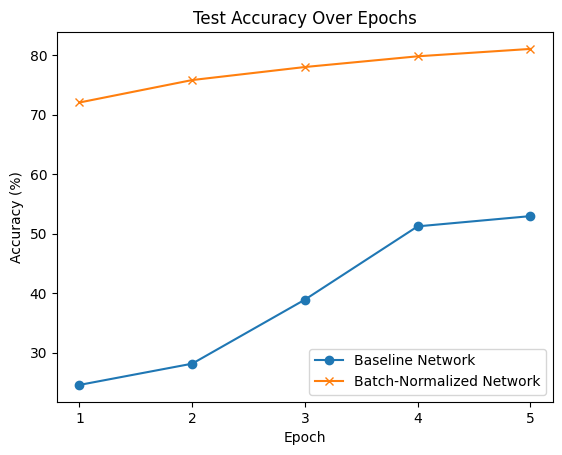

In [8]:
plt.plot(range(1, 6), baseline_accuracies, marker='o', label='Baseline Network')
plt.plot(range(1, 6), batchnorm_accuracies, marker='x', label='Batch-Normalized Network')
plt.xticks(range(1, 6))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

**Your Answer:**

- The baseline network shows a slow improvement in accuracy over epochs, starting around 25% and reaching til 55% after 5 epochs. The batch-normalized network starts with a much higher initial accuracy around 70%, indicating that it benefits from better-initialized distributions and faster learning.
- The progress per epoch is inconsistent in baseline network, with a noticeable plateau between epochs 2 and 4, indicating that the network struggles to learn efficiently. Whereas in batch-normalized network the improvement  is more consistent, with the accuracy reaching more than 80% after 5 epochs.
- The key difference is that batch norm stabilizes training by ensuring that inputs to each layer have a normalized distribution. This allows the network to converge faster. Also, assuming the baseline network can improve further with more epochs or hyperparameter tuning, it would still likely lag behind the batch-norm network due to its less stable learning process.
